# **Lab 3 : Pretrained models & CNN architecture**

## **Part A : Pretrained models from torchvision**

In [0]:
import torch
from torchvision import models, transforms, datasets
from torchsummary import summary

# Load ResNet152 model
model = models.resnet152(pretrained=True).to('cuda')

print(model)
summary(model, (3, 224, 224))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

--2020-05-12 17:17:51--  https://upload.wikimedia.org/wikipedia/commons/3/34/Labrador_on_Quantock_%282175262184%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 873248 (853K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 852.78K  2.27MB/s    in 0.4s    

2020-05-12 17:17:51 (2.27 MB/s) - ‘dog.jpg’ saved [873248/873248]

(1340, 883)


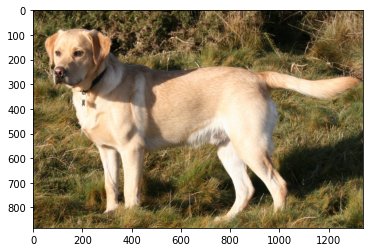

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Load an image to perform inference
!wget -O dog.jpg 'https://upload.wikimedia.org/wikipedia/commons/3/34/Labrador_on_Quantock_%282175262184%29.jpg'

image = Image.open('dog.jpg')
plt.imshow(image)
print(image.size)

In [0]:
import json

# Load 1000 class names of ImageNet for inference
! wget -O imagenet.json https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
with open('imagenet.json') as f:
  cls_dict = json.loads(f.read())

print(json.dumps(cls_dict, indent=2))

In [0]:
# Data augmentation
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
  mean=[0.485, 0.456, 0.406],                #[6]
  std=[0.229, 0.224, 0.225]                  #[7]
 )])

img = transform(image)

# Switch to eval mode!
model.eval()

# Perform forward pass
out = model(img.view(1,3,224,224))

# Get the top-5 predicted probabilities for each class
probabilities, cls_indices = torch.nn.functional.softmax(out, dim=-1).topk(5)
print(probabilities)
print(cls_indices)
cls_labels = [cls_dict[str(int(i))][-1] for i in cls_indices.view(-1)]
probabilities = probabilities.detach().numpy().squeeze() * 100
print(cls_labels)
for i in range(5):
  print(f'#{i+1}: {cls_labels[i]} -- {probabilities[i]:02.1f}%')

tensor([[0.6985, 0.1439, 0.0531, 0.0220, 0.0184]], grad_fn=<TopkBackward>)
tensor([[208, 273, 207, 225, 227]])
['Labrador_retriever', 'dingo', 'golden_retriever', 'malinois', 'kelpie']
#1: Labrador_retriever -- 69.9%
#2: dingo -- 14.4%
#3: golden_retriever -- 5.3%
#4: malinois -- 2.2%
#5: kelpie -- 1.8%


## **Part B : Creating a custom CNN**

Let's do the following steps in order :


1.   Load [Fashion-MNIST Dataset](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md) from [torchvision](https://pytorch.org/docs/stable/torchvision/index.html)
2.   Normalize our data and create train & test sets
3.   Create a custom CNN architecture
4.   Define loss function & optimization technique
5.   Train our network on train data






Ankle boot


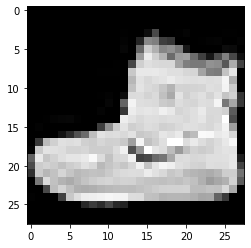

In [0]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Let's use Fashion-MNIST dataset
train_set = datasets.FashionMNIST('.', train=True, download=True)

# These are the labels of our dataset
cls_labels = {
  0:'T-shirt/top',
  1:'Trouser',
  2:'Pullover',
  3:'Dress',
  4:'Coat',
  5:'Sandal',
  6:'Shirt',
  7:'Sneaker',
  8:'Bag',
  9:'Ankle boot'
}

# Show the first image of our dataset
for img, label in train_set:
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  print(cls_labels[label])
  break

train_set = datasets.FashionMNIST('.', train=True, download=True, transform=transforms.ToTensor())

In [0]:
# Calculate dataset normalization statistics (mean and standard deviation)
mean = 0
std = 0
for image, label in train_set:
  mean += image.mean()
  std += image.std()
print(image.size())
train_mean = float(mean/len(train_set))
train_std = float(std/len(train_set))

print('mean:', train_mean,'\nstd:', train_std)

torch.Size([1, 28, 28])
mean: 0.28604063391685486 
std: 0.3204546272754669


In [0]:
from torch.utils.data import DataLoader

# Perform normalization 
transform = transforms.Compose([
 transforms.ToTensor(),         
 transforms.Normalize(          
  mean=train_mean,              
  std=train_std                 
 )])

# Create train & test set
train_set = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

# Create trainloader & testloader
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [0]:
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

# Define our own CNN architecture
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )
    self.dense1 = nn.Linear(24*3*3, 256)
    self.dense2 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.conv_features(x)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.dense1(x))
    x = self.dense2(x)
    return x

model = CNNModel().to('cuda')
print(model)
summary(model, (1, 28, 28), device='cuda')

CNNModel(
  (conv_features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense1): Linear(in_features=216, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
         

In [0]:
# Train our network
from torch.optim import SGD
import torch

num_epochs = 5

criterion = nn.CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
  total_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()

    logits = model(images.to('cuda'))

    loss = criterion(logits, labels.to('cuda'))
    loss.backward()

    optimizer.step()
    total_loss += float(loss.cpu().detach())

    y_pred = (torch.argmax(logits, axis=-1).cpu().detach().numpy())
  
  print(f'Epoch {epoch + 1}: total mean loss {total_loss/len(trainloader)}')

In [0]:
### Extra Notes ###
### Let's make some tests to calculate output shape ###
from torch import nn

conv_features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )
summary(conv_features, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
         MaxPool2d-3            [-1, 4, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]             592
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 24, 7, 7]           3,480
              ReLU-8             [-1, 24, 7, 7]               0
         MaxPool2d-9             [-1, 24, 3, 3]               0
Total params: 4,112
Trainable params: 4,112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.02
Estimated Total Size (MB): 0.15
-----------------------------------------------